In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions

print ('Success')

Welcome to JupyROOT 6.24/06
Success


# Reading in .pkl files

In [2]:
Params = {"Run":"run3", #The run number, so far either "run1" or "run3"
          "Load_standard":True,
          "Load_DetVars":True,
          "Only_keep_common_DetVar_evs":True,
          "Load_data":False,
          "FLATTEN":True, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":False} #Create small files containing only variables necessary for pre-selection, for making pre-selection plots

Params, samples = Functions.create_sample_list(Params)
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/"+Params["variables_string"]+"/"

Loading these run3 samples: 
['overlay', 'dirtoverlay', 'beamoff', 'signal', 'WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ', 'WireModdEdX', 'LYDown', 'LYRayleigh', 'LYAttenuation', 'SCE', 'Recomb2', 'CV']


In [3]:
# HNL_masses = Constants.HNL_mass_samples #in MeV

# Run = "run3" #so far either "run1" or "run3"

# only_presel = False #For small files containing only variables necessary for pre-selection, for making pre-selection plots
# FLATTEN = True

# Load_standard = True #Will load overlay, dirt, beamoff and signal samples for given Run
# Load_DetVars = True #Will load the overlay Detector Variation files
# Load_data = False #Will load the beamgood data for given Run

# if FLATTEN == True: Flat_state = "flattened"
# else: Flat_state = "unflattened"
    
# if only_presel:
#     variables_string = "Presel_vars"
# else:
#     variables_string = "my_vars"

# loc_pkls = f"pkl_files/{Run}/current_files/{variables_string}/"

# samples = [] #A list of all the samples which will be loaded in
# if Load_standard == True:
#     samples.extend(["overlay","dirtoverlay","beamoff","signal"])
# if Load_DetVars == True: #For overlay detector variations
#     samples.extend(Constants.Detector_variations)
# if Load_data == True:
#     samples.extend(["beamgood"])

# print(f"Loading these {Run} samples: " + "\n" + str(samples))

In [4]:
samples_dict = {}

for sample in samples:
    if sample in Constants.Detector_variations:
        file = pd.read_pickle(loc_pkls+"DetVars/overlay_"+Params["Run"]+"_"+Params["variables_string"]+f"_{sample}_"+Params["Flat_state"]+"_"+Params["Reduced_state"]+".pkl")
        samples_dict[sample] = file
    else:
        if Constants.sample_type[sample] == "MC_signal":
            for HNL_mass in Constants.HNL_mass_samples:
                file = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+".pkl")
                samples_dict[HNL_mass] = file
        else: 
            file = pd.read_pickle(loc_pkls+f"{sample}_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+".pkl")
            samples_dict[sample] = file


# Plotting variables before preselection

In [5]:
#Want to have arrows drawn on for where the preselection cut goes
HNL_mass = 200 #only plotting one at a time
variable = "crtveto"
samples_plotting = {"overlay":samples_dict["overlay"],
           "dirtoverlay":samples_dict["dirtoverlay"],
           "beamoff":samples_dict["beamoff"],
           "signal":samples_dict[HNL_mass]}
if Params["Run"] == "run1":
    sample_norms = {"overlay":Constants.SF_overlay_run1,
           "dirtoverlay":Constants.SF_dirt_run1,
           "beamoff":Constants.SF_EXT_run1,
           "signal":Constants.run1_POT_scaling_dict[HNL_mass]}
elif Params["Run"] == "run3":
    sample_norms = {"overlay":Constants.SF_overlay_run3,
           "dirtoverlay":Constants.SF_dirt_run3,
           "beamoff":Constants.SF_EXT_run3,
           "signal":Constants.run3_POT_scaling_dict[HNL_mass]}
    
PT.HNL_scaling_calculator(samples_plotting,sample_norms)


The ratio of overlay to HNL events is 49889

The ratio of all bkgs to HNL events is 108172



In [6]:
for sample in samples_plotting:
    print(sample)

overlay
dirtoverlay
beamoff
signal


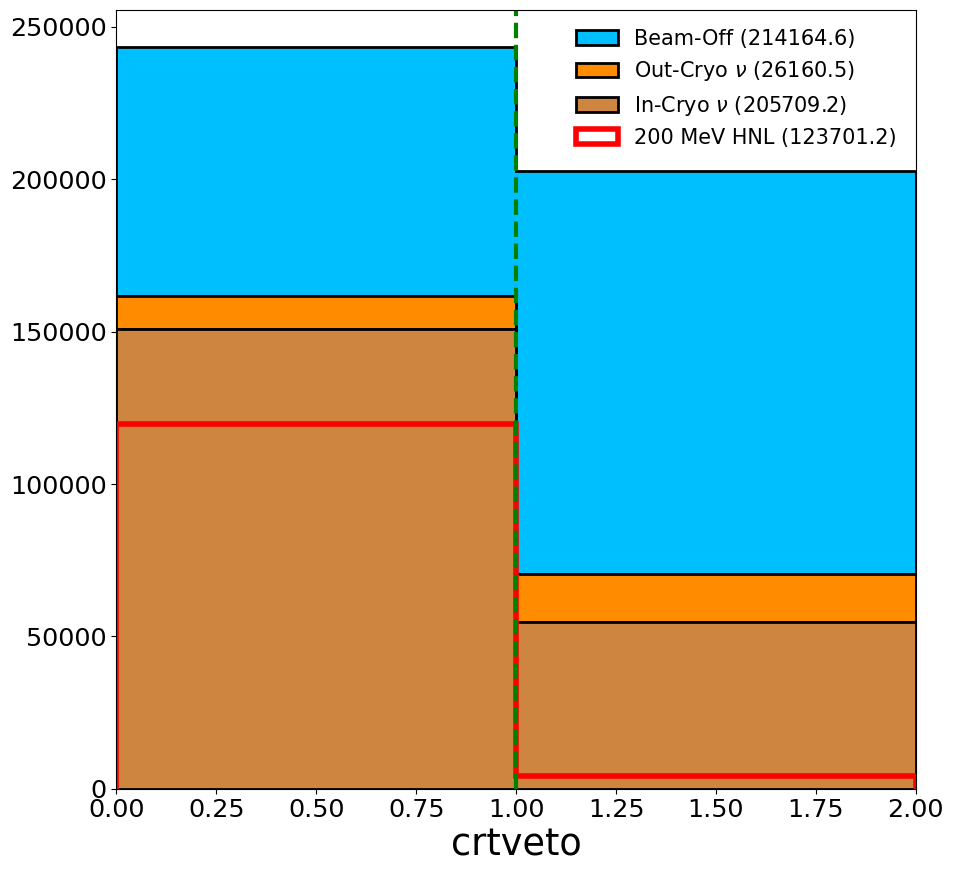

In [10]:
PT.Plot_preselection_variable(variable, samples_plotting, sample_norms, xlabel=[],xlims=[0,2],bins=2, HNL_mass=HNL_mass,HNLplotscale=30000,cutline=1.0)
# plt.axvline(x=16.5, lw=3, color='green', linestyle = 'dashed')

#plt.savefig("plots/Preselection_variables/" + Run + "_" + str(HNL_mass) + "_MeV_" + str(variable)+".png")

## Plot only signal samples before preselection

In [7]:
#Need a new plotting function for this


# Pre-selection cuts

In [7]:
def Preselection_weighted_efficiency(samples, cut_dict, Efficiency_dict, Preselected): #Need to account for weigthing in overlay and dirt samples
    for sample in samples:
        if sample == "overlay" or sample == "dirtoverlay" or sample in Constants.Detector_variations:
            weight = samples[sample]["weight"]
            NumEvs = sum(weight)
        else:
            NumEvs = len(samples[sample])
        
        effic_list = [1.0]
        for cut in cut_dict.keys():
            samples[sample]=samples[sample].query(cut_dict[cut])
            if sample == "overlay" or sample == "dirtoverlay" or sample in Constants.Detector_variations:
                weight = samples[sample]["weight"]
                Num_selected = sum(weight)
            else:
                Num_selected = len(samples[sample])
            effic_list.append(Num_selected/NumEvs)
        Efficiency_dict[sample]=effic_list
        #samples.update()
        Selected = samples[sample].copy()
        placeholder_dict = {sample:Selected}
        Preselected.update(placeholder_dict) 
    
def Preselection_DetVars(samples, cut_dict, Preselected): #Not making efficiency plots for DetVars
    for sample in samples:
        for cut in cut_dict.keys():
            samples[sample]=samples[sample].query(cut_dict[cut])
        Selected = samples[sample].copy()
        placeholder_dict = {sample:Selected}
        Preselected.update(placeholder_dict)

In [8]:
#Make cuts on signal
if Params["Run"] == "run1": 
    if Params["FLATTEN"] == True:
        Preselection_dict = Constants.Preselection_dict #Have also saved this in Constants.py, it is also here in case I want to add to or edit the cuts
    else:
        Preselection_dict = Constants.Preselection_dict_for_plot
elif Params["Run"] == "run3":
    if Params["FLATTEN"] == True:
        Preselection_dict = Constants.Preselection_dict
    else:
        Preselection_dict = Constants.Preselection_dict_for_plot
    Preselection_dict.update(Constants.Preselection_dict_crtveto) #Adding crtveto cut
    
print("Preselection is:" + "\n")
print(Preselection_dict)
print()


Preselection is:

{'nslice': 'nslice==1', 'flash_time': 'flash_time > 6.55 and flash_time < 16.5', 'nu_flashmatch_score': 'nu_flashmatch_score < 15', 'NeutrinoEnergy2': 'NeutrinoEnergy2 < 500', 'contained_fraction': 'contained_fraction > 0.9', 'trk_score_v': 'trk_score_v < 0.97', 'n_pfps': 'n_pfps < 6', 'crtveto': 'crtveto==0'}



In [9]:
#Make cuts on bkg
# Preselection_efficiency_overlay = [1.0]
# Preselection_efficiency_dirt = [1.0]
# Preselection_efficiency_EXT = [1.0]

# Preselection_signal_max = []
# Preselection_signal_min = []

# Preselection_efficiency_signal_dict = {}
# for HNL_mass in HNL_masses:
#     Preselection_efficiency_signal_dict[HNL_mass] = [1.0]

# Selected_signal_from_pkl_dict = {}

    
# Selected_overlay_from_pkl = Preselection_with_list(overlay_from_pkl, Preselection_dict, Preselection_efficiency_overlay)
# Selected_dirt_from_pkl = Preselection_with_list(dirt_from_pkl, Preselection_dict, Preselection_efficiency_dirt)
# Selected_EXT_from_pkl = Preselection_with_list(EXT_from_pkl, Preselection_dict, Preselection_efficiency_EXT)

# for HNL_mass in HNL_masses:
#     Selected_signal_from_pkl_dict[HNL_mass] = Preselection_with_list(signal_samples_dict[HNL_mass], Preselection_dict, Preselection_efficiency_signal_dict[HNL_mass])

# print("AFTER Preselection:")
# print("Overlay .pkl is "+str(len(Selected_overlay_from_pkl))+" entries long.")
# print("Dirt .pkl is "+str(len(Selected_dirt_from_pkl))+" entries long.")
# print("EXT .pkl is "+str(len(Selected_EXT_from_pkl))+" entries long.")

# for HNL_mass in HNL_masses:
#     print(f"{HNL_mass}MeV Signal .pkl is "+str(len(Selected_signal_from_pkl_dict[HNL_mass]))+" entries long.")

sample_dict_copy = {}
for sample in samples_dict:
    sample_dict_copy[sample] = samples_dict[sample].copy()

Efficiency_dict = {}
Preselected_dict = {}
    
Preselection_weighted_efficiency(sample_dict_copy, Preselection_dict, Efficiency_dict, Preselected_dict)

#print(Efficiency_dict)

## Detector Variations selection

In [10]:
# if Load_DetVars == True:
#     DetVars = Constants.Detector_variations
#     DetVar_preselected = {}

#     Preselection_DetVars(DetVar_samples, Preselection_dict, DetVar_preselected)

#     for DetVar in DetVars:
#         DetVar_preselected[DetVar].to_pickle(loc_pkls+"DetVars/"+f"Preselected_overlay_{Run}_{variables_string}_{DetVar}_flattened.pkl")

In [11]:
#Working out the maximum and minimum efficiencies for signal "band"
Preselection_signal_max = []
Preselection_signal_min = []

max_presel_effic = 0.0 #Placeholder to record the highest efficiency
min_presel_effic = 1.0 #Placeholder to record the lowest efficiency
# for i in range(len(Preselection_dict)+1):
#     for HNL_mass in HNL_masses:
#         if Preselection_efficiency_signal_dict[HNL_mass][i] > max_presel_effic:
#             max_presel_effic = Preselection_efficiency_signal_dict[HNL_mass][i]
#         if Preselection_efficiency_signal_dict[HNL_mass][i] < min_presel_effic:
#             min_presel_effic = Preselection_efficiency_signal_dict[HNL_mass][i]
#     Preselection_signal_max.append(max_presel_effic)
#     Preselection_signal_min.append(min_presel_effic)
#     max_presel_effic = 0.0
    
for i in range(len(Preselection_dict)+1):
    for HNL_mass in Constants.HNL_mass_samples:
        if Efficiency_dict[HNL_mass][i] > max_presel_effic:
            max_presel_effic = Efficiency_dict[HNL_mass][i]
        if Efficiency_dict[HNL_mass][i] < min_presel_effic:
            min_presel_effic = Efficiency_dict[HNL_mass][i]
    Preselection_signal_max.append(max_presel_effic)
    Preselection_signal_min.append(min_presel_effic)
    max_presel_effic = 0.0

In [12]:
print(Preselection_signal_max)
print(Preselection_signal_min)

[1.0, 1.0, 0.9712101053171537, 0.9015917798118077, 0.8966865973101646, 0.6995729847494553, 0.6911023965141612, 0.6751023965141613, 0.661124183006536]
[1.0, 1.0, 0.9683481701285855, 0.8850034622613513, 0.8797441223991822, 0.6640564218786997, 0.653451950072726, 0.6468051280316612, 0.6313635287352434]


In [13]:
print(Preselected_dict.keys())

dict_keys(['overlay', 'dirtoverlay', 'beamoff', 20, 50, 100, 150, 180, 200, 'WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ', 'WireModdEdX', 'LYDown', 'LYRayleigh', 'LYAttenuation', 'SCE', 'Recomb2', 'CV'])


## Only select highest energy object and "Prepare" for xgboost

In [49]:
def Prepare_dfs_for_xgb(df): #The default value for missing data in XGB is 0. So this changes those very large negative values to -9999.
    value = -1e15
    new_value = -9999
    first_entry = df.index[0]
    for variable in df.keys():
        if isinstance(df[variable][first_entry], (int,float,np.int32,np.float32,np.uint32)):
        # if variable=='rse_id': #Should come up with a better way of checking the "type" of variable, in case it is not int or float.
        #     continue           #But don't know how to access the first extant row of a dataframe (since some have been removed). 
        # else: 
            if(len(df.loc[df[variable] < value]) > 0):
                df.loc[(df[variable] < value), variable] = new_value #Sets the new value
            if(len(df.loc[df[variable] == -1.0]) > 0):
                df.loc[(df[variable] == -1.0), variable] = new_value #Sets the new value
            if(len(df.loc[df[variable] == np.nan]) > 0):
                df.loc[(df[variable] == np.nan), variable] = new_value #Sets the new value
            if(len(df.loc[df[variable] == np.inf]) > 0):
                df.loc[(df[variable] == np.inf), variable] = new_value #Sets the new value
        # else:
        #     print(variable)
            
    df_edited = df.copy() 
    return df_edited

In [14]:
Prepared_dict = {}
for sample in Preselected_dict:
    Highest_E_placeholder = Functions.only_keep_highest_E(Preselected_dict[sample])
    Prepared_dict[sample] = Functions.Prepare_dfs_for_xgb(Highest_E_placeholder)
print(Prepared_dict.keys())

dict_keys(['overlay', 'dirtoverlay', 'beamoff', 20, 50, 100, 150, 180, 200, 'WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ', 'WireModdEdX', 'LYDown', 'LYRayleigh', 'LYAttenuation', 'SCE', 'Recomb2', 'CV'])


# Save pkls

In [15]:
print_vals = input("Do you want to save the pickle files? y/n ")
if print_vals == "y":
    loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/"+Params["variables_string"]+"/"
    
    for sample in Preselected_dict:
        print("Saving "+Params["Run"]+f" Preselected {sample} .pkl")
        if sample in Constants.Detector_variations:
            #Preselected_dict[sample].to_pickle(loc_pkls+"DetVars/"+"Preselected_overlay_"+Params["Run"]+"_"+Params["variables_string"]+f"_{sample}_"+Params["Flat_state"]+"_"+Params["Reduced_state"]+".pkl")
            Prepared_dict[sample].to_pickle(loc_pkls+"DetVars/"+"Preselected_overlay_"+Params["Run"]+"_"+Params["variables_string"]+f"_{sample}_"+Params["Flat_state"]+"_"+Params["Reduced_state"]+".pkl")
        else:
            #Preselected_dict[sample].to_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+".pkl")
            Prepared_dict[sample].to_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+".pkl")

#     print(f"Saving {Run} Preselected overlay .pkl")
#     Selected_overlay_from_pkl.to_pickle(loc_pkls+f"Preselected_overlay_{Run}_my_vars_flattened.pkl")

#     print(f"Saving {Run} Preselected dirt .pkl")
#     Selected_dirt_from_pkl.to_pickle(loc_pkls+f"Preselected_dirt_{Run}_my_vars_flattened.pkl")

#     print(f"Saving {Run} Preselected EXT .pkl")
#     Selected_EXT_from_pkl.to_pickle(loc_pkls+f"Preselected_EXT_{Run}_my_vars_flattened.pkl")
#     for HNL_mass in HNL_masses:
#         print(f"Saving {Run} Preselected {HNL_mass}MeV signal .pkl")
#         Selected_signal_from_pkl_dict[HNL_mass].to_pickle(loc_pkls+f"Preselected_signal_{HNL_mass}MeV_{Run}_my_vars_flattened.pkl")
else:
    print("Not saving pickle files, move onto next cell")

Do you want to save the pickle files? y/n  y


Saving run3 Preselected overlay .pkl
Saving run3 Preselected dirtoverlay .pkl
Saving run3 Preselected beamoff .pkl
Saving run3 Preselected 20 .pkl
Saving run3 Preselected 50 .pkl
Saving run3 Preselected 100 .pkl
Saving run3 Preselected 150 .pkl
Saving run3 Preselected 180 .pkl
Saving run3 Preselected 200 .pkl
Saving run3 Preselected WireModX .pkl
Saving run3 Preselected WireModYZ .pkl
Saving run3 Preselected WireModThetaXZ .pkl
Saving run3 Preselected WireModThetaYZ .pkl
Saving run3 Preselected WireModdEdX .pkl
Saving run3 Preselected LYDown .pkl
Saving run3 Preselected LYRayleigh .pkl
Saving run3 Preselected LYAttenuation .pkl
Saving run3 Preselected SCE .pkl
Saving run3 Preselected Recomb2 .pkl
Saving run3 Preselected CV .pkl


# Plotting Efficiencies

Do you want to save the figure? y/n  n


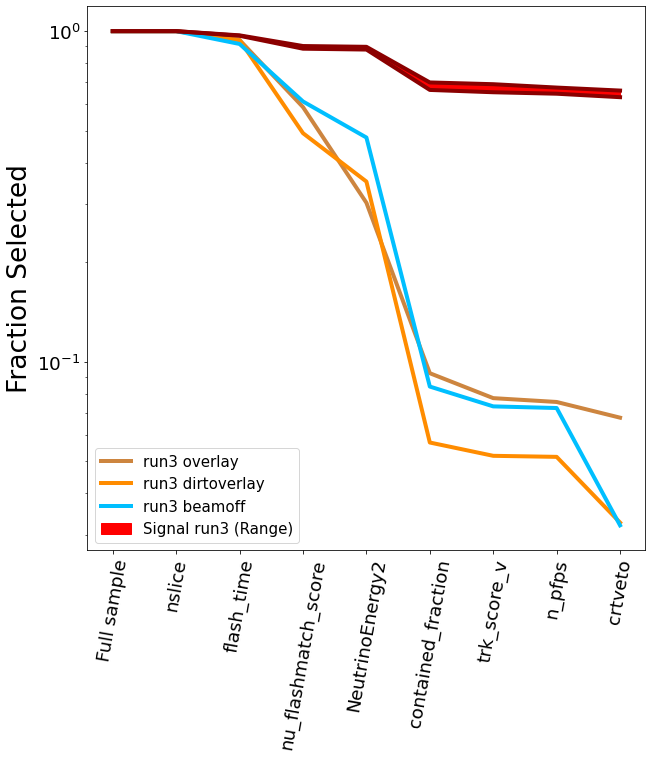

In [20]:
#Signal-only efficiencies
plt.figure(figsize=[10,10])
#print(Preselection_efficiency_signal_dict)
#print(len(Preselection_efficiency_signal_dict[HNL_mass]))
# for HNL_mass in HNL_masses:
#     plt.plot(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)), Preselection_efficiency_signal_dict[HNL_mass], label=f"{HNL_mass} MeV HNL",lw=4,markersize=15)
#plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_signal,label="100 MeV HNL",lw=4,markersize=15)


# plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_overlay,label=f"MC {Run} overlay",color='peru',lw=4,markersize=15)
# plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_dirt,label=f"MC {Run} dirt",color="darkorange",lw=4,markersize=15)
# plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_EXT,label=f"{Run} EXT",color='deepskyblue',lw=4,markersize=15)
# plt.plot(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),Preselection_signal_max,color="darkred",lw=4,marker="")
# plt.plot(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),Preselection_signal_min,color="darkred",lw=4,marker="")
# plt.fill_between(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),Preselection_signal_min,Preselection_signal_max,label=f"Signal {Run} (Range)",color="red")
# plt.ylabel("Fraction Selected")
# plt.xticks(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
# #plt.yscale("log")
# plt.legend()

plotting_effic_dict = {'overlay':Efficiency_dict['overlay'], 'dirtoverlay':Efficiency_dict['dirtoverlay'],
                      'beamoff':Efficiency_dict['beamoff']}
plotting_effic_colours = {'overlay':'peru', 'dirtoverlay':'darkorange',
                      'beamoff':'deepskyblue'}
#, 'signal_max':Preselection_signal_max, 'signal_min':Preselection_signal_min}

log = True

if log == True:
    logscale="log"
elif log == False:
    logscale="linear"

for effic in plotting_effic_dict:
    #Efficiency_dict[effic]
    plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[effic],label=Params["Run"]+f" {effic}",color=plotting_effic_colours[effic],lw=4,markersize=15)

plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Preselection_signal_max,color="darkred",lw=4,marker="")
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Preselection_signal_min,color="darkred",lw=4,marker="")
plt.fill_between(np.array(range(1, len(Efficiency_dict[effic])+1)),Preselection_signal_min,Preselection_signal_max,label="Signal "+Params["Run"]+" (Range)",color="red")
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict['overlay'])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
plt.yscale(logscale)
plt.legend()

save_fig = input("Do you want to save the figure? y/n ")

if save_fig == 'y':
    plt.savefig("plots/Preselection_efficiencies/"+Params["Run"]+"_"+Params["Flat_state"]+"_" + logscale + ".png")

[1.0, 0.5580340693291006, 0.542388254301182, 0.49757659930274084, 0.4948839318613418, 0.37113460502820217, 0.36614608429466283]


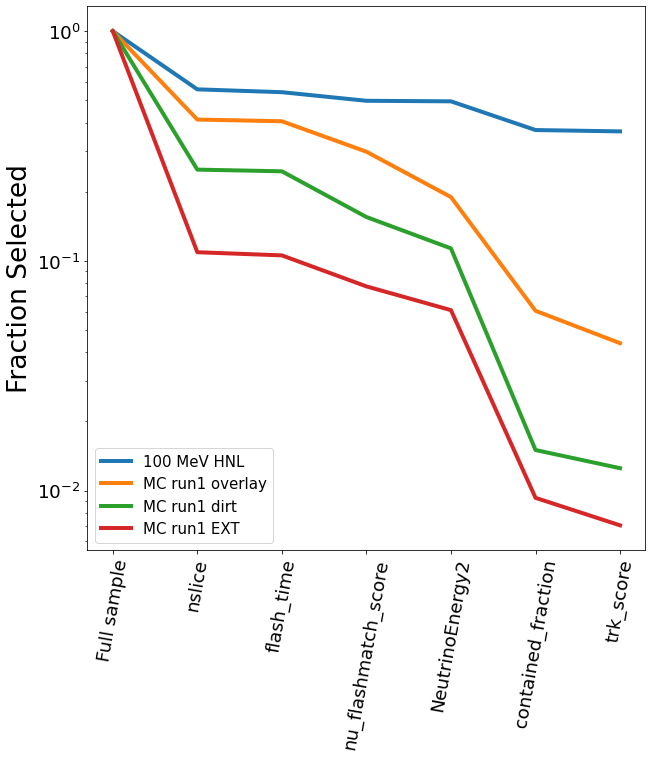

In [15]:
#Plotting efficiency
plt.figure(figsize=[10,10])
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_signal,label="100 MeV HNL",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_overlay,label="MC run1 overlay",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_dirt,label="MC run1 dirt",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_EXT,label="MC run1 EXT",lw=4,markersize=15)
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Preselection_efficiency_signal)+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
#plt.yscale("log")
plt.legend()

print(Preselection_efficiency_signal)


# Testing code

In [ ]:
#Testing what the variables look like
variable = "dvtx_x_boundary"
def test_variables(df):
    test_signal = df[variable]
    print(type(test_signal))
    print(len(test_signal))
test_variables(df_overlay_run1)
test_variables(df_dirt_run1)
test_variables(df_EXT_run1)
test_variables(df_signal_run1)

In [ ]:
#print(overlay_from_pkl['nslice'])
#print("Flat Overlay .pkl is "+str(len(FLAT_overlay_from_pkl))+" entries long.")

print("-----Unflattened-----")
unique_var = overlay_from_pkl["nslice"].unique()
print(unique_var)
unique_var = overlay_from_pkl["n_pfps"].unique()
print(unique_var)
print(overlay_from_pkl["n_pfps"])
print(type(overlay_from_pkl["n_pfps"][0]))

# for var in overlay_from_pkl.keys():
#     if type(overlay_from_pkl[var][1]) == "numpy.ndarray":
#         print(var)

# print("-----Flattened-----")
# unique_var = FLAT_overlay_from_pkl["nslice"].unique()
# print(unique_var)
# unique_var = FLAT_overlay_from_pkl["n_pfps"].unique()
# print(unique_var)
# print(FLAT_overlay_from_pkl["n_pfps"])
# print(type(FLAT_overlay_from_pkl["n_pfps"]))